In [5]:
%reload_ext autoreload
%autoreload 2

In [6]:
from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats
from statannot import add_stat_annotation

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# load data

In [243]:
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup"
# )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr"
# )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr_v2"
# )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr_w_theta"
# )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr_w_uid_new_deep_sup_fixed_corr_w_theta_single_bin"
# )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_v3"
#     )
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_v3_with_post_restrict"
#     )
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_v3_with_post_restrict_60"
    )
ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)

pairwise_corr_df["corrcoef"] = pairwise_corr_df["corr"] 
pairwise_corr_df = pairwise_corr_df.drop(["corr"], axis=1)

pairwise_corr_df.loc[pairwise_corr_df.region == "EC1|EC2|EC3|EC4|EC5|MEC", "region"] = "MEC"
pairwise_corr_df = pairwise_corr_df[~np.isnan(pairwise_corr_df['corrcoef'])]
pairwise_corr_df.reset_index(drop=True, inplace=True)

In [244]:
pairwise_corr_df

,epoch,region,sublayer,ref_uid,target_uid,basepath,corrcoef
0,pre,MEC,Deep,59.0,87.0,Z:\Data\AYAold\AYA7\day19,-0.022261
1,pre,MEC,Deep,59.0,89.0,Z:\Data\AYAold\AYA7\day19,-0.000066
2,pre,MEC,Deep,59.0,90.0,Z:\Data\AYAold\AYA7\day19,-0.006871
3,pre,MEC,Deep,59.0,91.0,Z:\Data\AYAold\AYA7\day19,0.045656
4,pre,MEC,Deep,59.0,92.0,Z:\Data\AYAold\AYA7\day19,-0.022555
...,...,...,...,...,...,...,...
246882,post,PFC,Deep,21.0,38.0,Z:\Data\ORproject\OR18\day2,-0.048954
246883,post,PFC,Deep,21.0,39.0,Z:\Data\ORproject\OR18\day2,0.021759
246884,post,PFC,Deep,21.0,40.0,Z:\Data\ORproject\OR18\day2,-0.173238
246885,post,PFC,Deep,21.0,46.0,Z:\Data\ORproject\OR18\day2,0.001259


In [245]:
pairwise_corr_df["region_sublayer"] = pairwise_corr_df["sublayer"] + "_" + pairwise_corr_df["region"]
pairwise_corr_df["r2"] = pairwise_corr_df["corrcoef"] ** 2


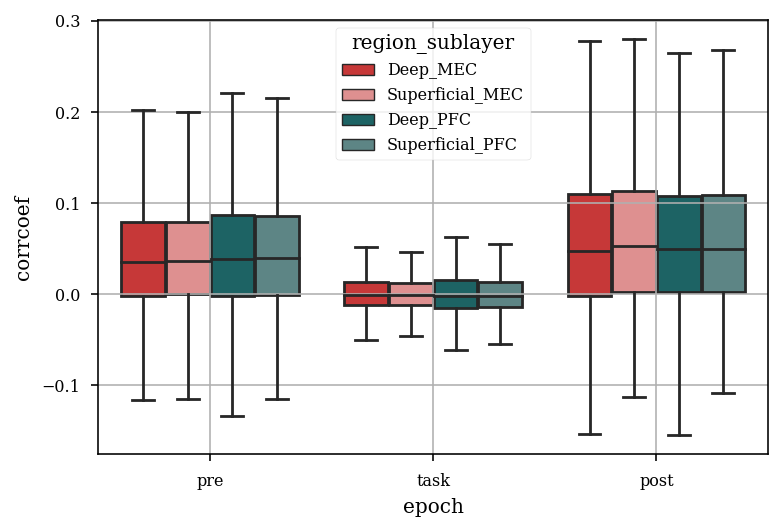

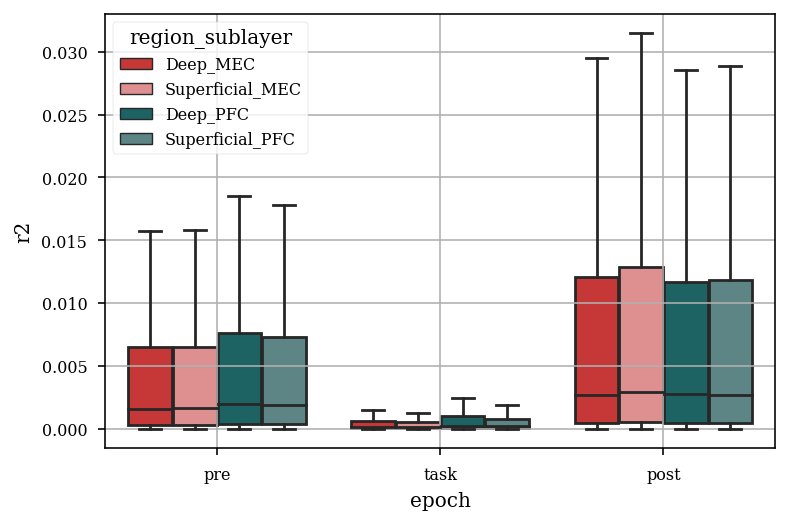

In [246]:
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
group_colors = {
    "Deep_MEC": "#de2020",
    "Superficial_MEC": "#eb8383",
    "Deep_PFC": "#116f70",
    "Superficial_PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))
sns.boxplot(x="epoch", y="corrcoef",hue="region_sublayer",hue_order=group_colors.keys(), data=pairwise_corr_df, showfliers=False)
# sns.stripplot(x="epoch", y="corrcoef",hue="region_sublayer", data=pairwise_corr_df,dodge=True,color='k',alpha=.2)
plt.grid()
plt.show()

sns.boxplot(x="epoch", y="r2",hue="region_sublayer",hue_order=group_colors.keys(), data=pairwise_corr_df, showfliers=False)
# sns.stripplot(x="epoch", y="corrcoef",hue="region_sublayer", data=pairwise_corr_df,dodge=True,color='k',alpha=.2)
plt.grid()
plt.show()

In [247]:
pairwise_corr_df["corrcoef_abs"] = np.abs(pairwise_corr_df["corrcoef"])

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

pre_Deep_PFC v.s. pre_Superficial_PFC: t-test independent samples with Bonferroni correction, P_val=3.151e-04 stat=3.779e+00
pre_Deep_MEC v.s. pre_Superficial_MEC: t-test independent samples with Bonferroni correction, P_val=9.548e-01 stat=-7.105e-01


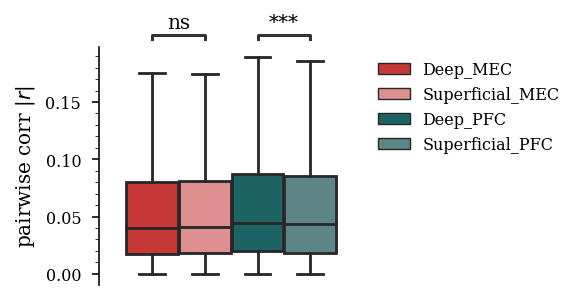

In [248]:
w,h = functions.set_size("thesis", fraction=0.2, subplots=(3, 1))
group_colors = {"Deep": "#7b3294", "Superficial": "#008837"}
group_colors = {
    "Deep_MEC": "#de2020",
    "Superficial_MEC": "#eb8383",
    "Deep_PFC": "#116f70",
    "Superficial_PFC": "#568c8c",
}
sns.set_palette(sns.color_palette(group_colors.values()))
fig = plt.figure(
    figsize=(w*2,h), edgecolor=None
)

sns.boxplot(x="epoch", y="corrcoef_abs",hue="region_sublayer", hue_order=group_colors.keys(),
            data=pairwise_corr_df[(pairwise_corr_df.epoch == "pre")],showfliers=False)
sns.despine(bottom=True)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())
plt.ylabel('pairwise corr $|r|$')
# plt.yscale("log")
plt.legend(
    bbox_to_anchor=(1.8, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
# box_pairs = [
#     (("MEC", "Deep"), ("MEC", "Superficial")),
#     (("PFC", "Deep"), ("PFC", "Superficial")),
# ]
box_pairs = [
    (("pre", "Deep_MEC"), ("pre", "Superficial_MEC")),
    (("pre", "Deep_PFC"), ("pre", "Superficial_PFC")),
]
add_stat_annotation(
    plt.gca(),
    x="epoch",
    y="corrcoef_abs",
    hue="region_sublayer",
    data=pairwise_corr_df[(pairwise_corr_df.epoch == "pre")],
    box_pairs=box_pairs,
    test="t-test_ind",
    text_format="star",
    loc="outside",
    verbose=2,
)
plt.gca().get_xaxis().set_visible(False)
ax = plt.gca()
ax.yaxis.set_minor_locator(AutoMinorLocator())

plt.savefig(
    os.path.join(fig_save_path, "co_fire_deep_sup_readout_regions.svg"),
    dpi=300,
    bbox_inches="tight",
)

In [249]:
for basepath in pairwise_corr_df.basepath.unique():
    session_idx = pairwise_corr_df.basepath == basepath
    for epoch in pairwise_corr_df[session_idx].epoch.unique():
        epoch_idx = (pairwise_corr_df.epoch == epoch) & (pairwise_corr_df.basepath == basepath)
        pairwise_corr_df.loc[epoch_idx, "session_idx"] = np.arange(sum(epoch_idx))

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=9.454e-04 stat=3.779e+00
MEC_Deep v.s. MEC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.000e+00 stat=-7.105e-01
MEC_Superficial v.s. PFC_Deep: t-test independent samples with Bonferroni correction, P_val=5.658e-20 stat=-9.347e+00
MEC_Deep v.s. PFC_Deep: t-test independent samples with Bonferroni correction, P_val=1.863e-36 stat=-1.276e+01
MEC_Superficial v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=7.466e-09 stat=-6.076e+00
MEC_Deep v.s. PFC_Superficial: t-test independent samples with Bonferroni correction, P_val=1.458e-15 stat=-8.202e+00


(<AxesSubplot:xlabel='region', ylabel='corrcoef_abs'>,
  <statannot.StatResult.StatResult at 0x21f90a04ee0>])

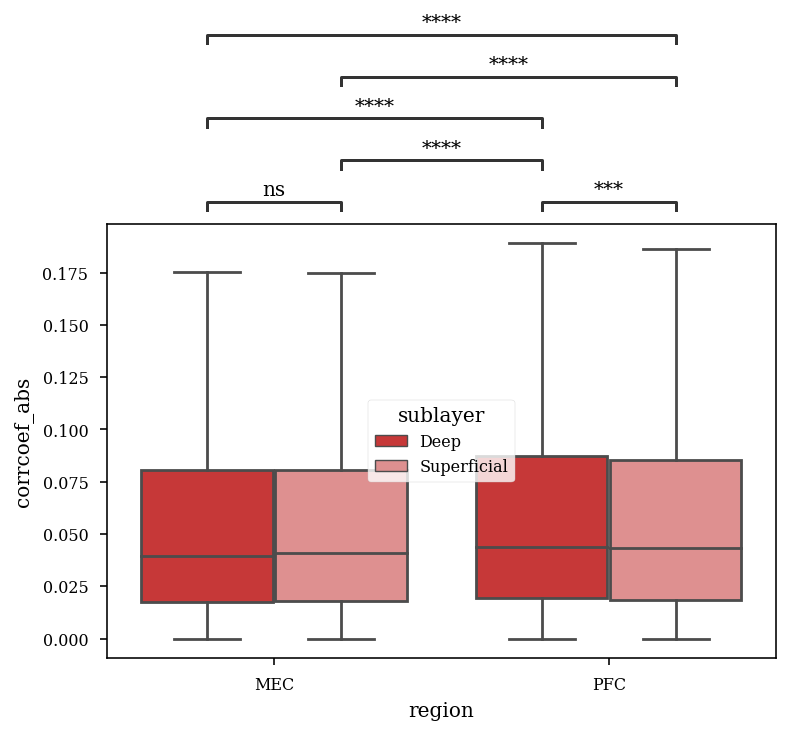

In [250]:
pre_df = pairwise_corr_df[pairwise_corr_df.epoch == "pre"]

sns.boxplot(
    x="region",
    y="corrcoef_abs",
    hue="sublayer",
    data=pre_df,
    showfliers=False,
)
# plt.yscale("log")
box_pairs = [
    (("MEC", "Deep"), ("MEC", "Superficial")),
    (("PFC", "Deep"), ("PFC", "Superficial")),
    (("PFC", "Deep"), ("MEC", "Deep")),
    (("PFC", "Superficial"), ("MEC", "Superficial")),
    (("PFC", "Superficial"), ("MEC", "Deep")),
    (("PFC", "Deep"), ("MEC", "Superficial")),

]
add_stat_annotation(
    plt.gca(),
    x="region",
    y="corrcoef_abs",
    hue="sublayer",
    data=pre_df,
    box_pairs=box_pairs,
    test="t-test_ind",
    text_format="star",
    loc="outside",
    verbose=2,
)

In [251]:
df_wide = pd.pivot(
    pairwise_corr_df, index=["basepath","region","sublayer","region_sublayer","session_idx","ref_uid","target_uid"], columns="epoch", values=["corrcoef"]
).reset_index()

df_wide["corrcoef_pre_post"] = (df_wide["corrcoef"]["pre"] - df_wide["corrcoef"]["post"])
df_wide["corrcoef_pre_post_abs"] = np.abs(df_wide["corrcoef_pre_post"])
# df_wide["r2_pre_post"] = (df_wide["corrcoef"]["pre"]**2 - df_wide["corrcoef"]["post"]**2)
# df_wide["r2_pre_post"] = (df_wide["corrcoef"]["pre"]**2 - df_wide["corrcoef"]["post"]**2) / (df_wide["corrcoef"]["pre"]**2 + df_wide["corrcoef"]["post"]**2)
df_wide["r2_pre_post"] = (df_wide["corrcoef"]["pre"]**2 - df_wide["corrcoef"]["post"]**2)
df_wide

basepath region sublayer region_sublayer  \
epoch                                                                 
0         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
1         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
2         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
3         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
4         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
...                             ...    ...      ...             ...   
134434  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
134435  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
134436  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
134437  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
134438  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   

       session_idx ref_uid target_uid  corrcoef                      \
epoch                                      post       pre      task   
0              0.0    59.0       87.0 -0.008287 -0.022261  0.000217   
1              1.0    59.0       89.0  0.039765 -0.000066 -0.009052   
2              2.0    59.0       90.0  0.201934 -0.006871  0.011609   
3              3.0    59.0       91.0  0.009106  0.045656 -0.007629   
4              4.0    59.0       92.0  0.020502 -0.022555 -0.020359   
...            ...     ...        ...       ...       ...       ...   
134434       204.0    21.0       38.0 -0.048954  0.141564  0.003816   
134435       205.0    21.0       39.0  0.021759  0.328047 -0.018767   
134436       206.0    21.0       40.0 -0.173238  0.026711  0.001035   
134437       207.0    21.0       46.0  0.001259  0.041279  0.012485   
134438       208.0    21.0       49.0  0.070322  0.113797  0.040270   

       corrcoef_pre_post corrcoef_pre_post_abs r2_pre_post  
epoch                                                       
0              -0.013974              0.013974    0.000427  
1              -0.039831              0.039831   -0.001581  
2              -0.208804              0.208804   -0.040730  
3               0.036551              0.036551    0.002002  
4              -0.043057              0.043057    0.000088  
...                  ...                   ...         ...  
134434          0.190518              0.190518    0.017644  
134435          0.306287              0.306287    0.107141  
134436          0.199950              0.199950   -0.029298  
134437          0.040020              0.040020    0.001702  
134438          0.043475              0.043475    0.008005  

[134439 rows x 13 columns]

In [ ]:
# df_wide['corrcoef'].unstack().plot()
# corrcoef
# sns.lineplot(x='post', y='corrcoef', style='task', data=df_wide.reset_index())
# df_wide.reset_index()
# df_wide.unstack().keys()

In [252]:
df_wide["corrcoef_pre"] = df_wide["corrcoef","pre"]
df_wide["corrcoef_post"] = df_wide["corrcoef","post"]
df_wide["corrcoef_task"] = df_wide["corrcoef","task"]

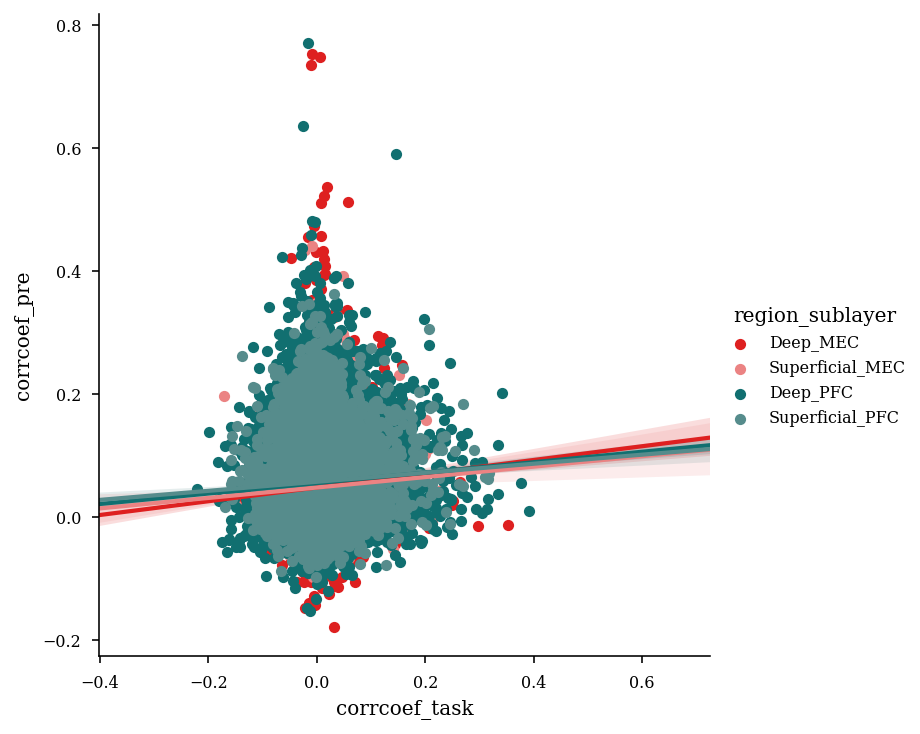

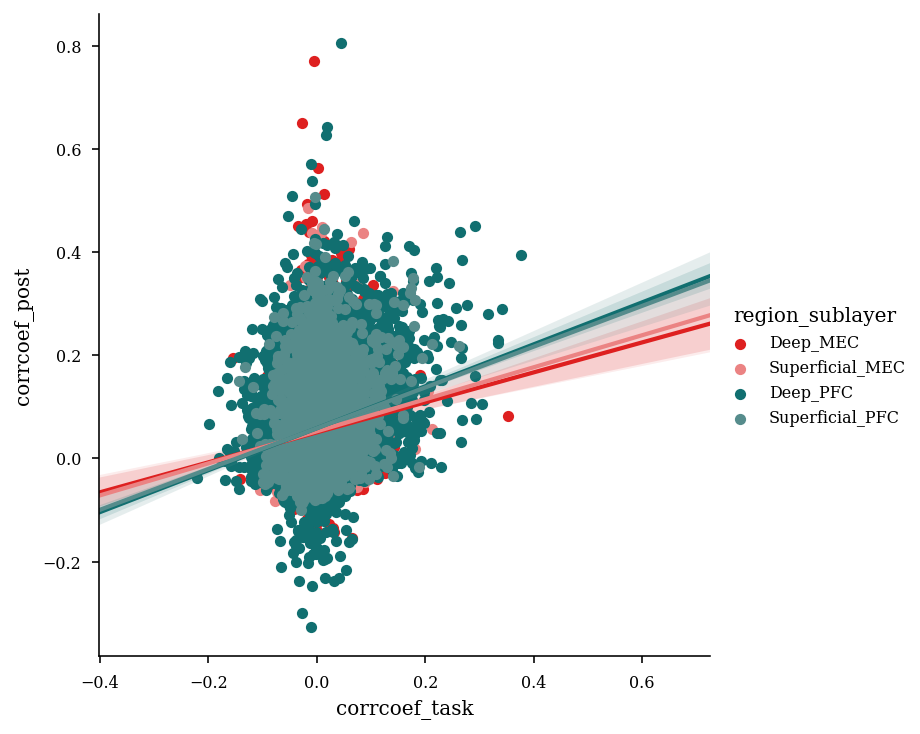

In [253]:
sns.lmplot(
    x="corrcoef_task",
    y="corrcoef_pre",
    hue="region_sublayer",
    data=df_wide,
    truncate=False,
    sharex=True,
    sharey=True,
    scatter_kws={"alpha": 1},
)
plt.show()

sns.lmplot(
    x="corrcoef_task",
    y="corrcoef_post",
    hue="region_sublayer",
    data=df_wide,
    truncate=False,
    sharex=True,
    sharey=True,
    scatter_kws={"alpha": 1},
)
plt.show()
# sns.scatterplot(x="corrcoef_pre",y="corrcoef_post",hue="region_sublayer", data=df_wide)

# plt.xscale("log")
# plt.yscale("log")


In [254]:
def get_r2(X, y):
    bad_idx = np.isnan(X) | np.isnan(y)
    X = X[~bad_idx].reshape(-1, 1)
    y = y[~bad_idx]
    # if (len(X) < 10) | (len(y) < 10):
    #     return np.nan
    reg = make_pipeline(StandardScaler(), LinearRegression())
    reg.fit(X, y)
    return reg.score(X, y), mean_squared_error(y, reg.predict(X),squared=False)

X = df_wide[(df_wide.region_sublayer == "Deep_MEC")].corrcoef_task.values
y = df_wide[(df_wide.region_sublayer == "Deep_MEC")].corrcoef_post.values
r2_, mse_ = get_r2(X, y)
print(r2_, mse_)

X = df_wide[(df_wide.region_sublayer == "Superficial_MEC")].corrcoef_task.values
y = df_wide[(df_wide.region_sublayer == "Superficial_MEC")].corrcoef_post.values
r2_, mse_ = get_r2(X, y)
print(r2_, mse_)

X = df_wide[(df_wide.region_sublayer == "Deep_PFC")].corrcoef_task.values
y = df_wide[(df_wide.region_sublayer == "Deep_PFC")].corrcoef_post.values
r2_, mse_ = get_r2(X, y)
print(r2_, mse_) 

X = df_wide[(df_wide.region_sublayer == "Superficial_PFC")].corrcoef_task.values
y = df_wide[(df_wide.region_sublayer == "Superficial_PFC")].corrcoef_post.values
r2_, mse_ = get_r2(X, y)
print(r2_, mse_)

0.008754909942905176 0.0755936317778426
0.008790441793189108 0.07308242719333187
0.034438729571937055 0.07610668507229103
0.022555976511942633 0.07508217637516866


In [255]:
# df_wide.basepath.value_counts()
from sklearn.linear_model import LinearRegression
# from sklearn.linear_model import Ridge
# from sklearn.linear_model import RidgeCV
# from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
# from sklearn.kernel_ridge import KernelRidge
# from sklearn.linear_model import HuberRegressor
from sklearn.metrics import mean_squared_error

def get_r2(X, y):
    bad_idx = np.isnan(X) | np.isnan(y)
    X = X[~bad_idx].reshape(-1, 1)
    y = y[~bad_idx]
    # if (len(X) < 10) | (len(y) < 10):
    #     return np.nan
    reg = make_pipeline(StandardScaler(), LinearRegression())
    reg.fit(X, y)
    return reg.score(X, y), mean_squared_error(y, reg.predict(X),squared=False)

r2 = []   
label = [] 
epoch_type = []
basepath_store = []
mse = []
for epoch in ["corrcoef_pre","corrcoef_post"]:
    for basepath in df_wide.basepath.unique():
        X = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Deep_MEC")].corrcoef_task.values
        y = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Deep_MEC")][epoch].values
        try:
            r2_, mse_ = get_r2(X, y)
            r2.append(r2_)
            mse.append(mse_)
        except:
            r2.append(np.nan)
            mse.append(np.nan)
        label.append("Deep_MEC")
        epoch_type.append(epoch)
        basepath_store.append(basepath)

        X = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Superficial_MEC")].corrcoef_task.values
        y = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Superficial_MEC")][epoch].values
        try:
            r2_, mse_ = get_r2(X, y)
            r2.append(r2_)
            mse.append(mse_)
        except:
            r2.append(np.nan)
            mse.append(np.nan)
        label.append("Superficial_MEC")
        epoch_type.append(epoch)
        basepath_store.append(basepath)

        X = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Deep_PFC")].corrcoef_task.values
        y = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Deep_PFC")][epoch].values
        try:
            r2_, mse_ = get_r2(X, y)
            r2.append(r2_)
            mse.append(mse_)
        except:
            r2.append(np.nan)
            mse.append(np.nan)
        label.append("Deep_PFC")
        epoch_type.append(epoch)
        basepath_store.append(basepath)

        X = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Superficial_PFC")].corrcoef_task.values
        y = df_wide[(df_wide.basepath == basepath) & (df_wide.region_sublayer == "Superficial_PFC")][epoch].values
        try:
            r2_, mse_ = get_r2(X, y)
            r2.append(r2_)
            mse.append(mse_)
        except:
            r2.append(np.nan)
            mse.append(np.nan)
        label.append("Superficial_PFC")
        epoch_type.append(epoch)
        basepath_store.append(basepath)
        
corr_df = pd.DataFrame({"r2":r2, "rmse":mse, "label":label, "epoch_type":epoch_type, "basepath":basepath_store})


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Superficial_MEC_corrcoef_pre v.s. Superficial_MEC_corrcoef_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.684e-01 U_stat=6.300e+01
Deep_MEC_corrcoef_pre v.s. Deep_MEC_corrcoef_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=3.580e+02
Deep_PFC_corrcoef_pre v.s. Deep_PFC_corrcoef_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=5.236e-01 U_stat=2.600e+01
Superficial_PFC_corrcoef_pre v.s. Superficial_PFC_corrcoef_post: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=6.349e-02 U_stat=1.000e+00


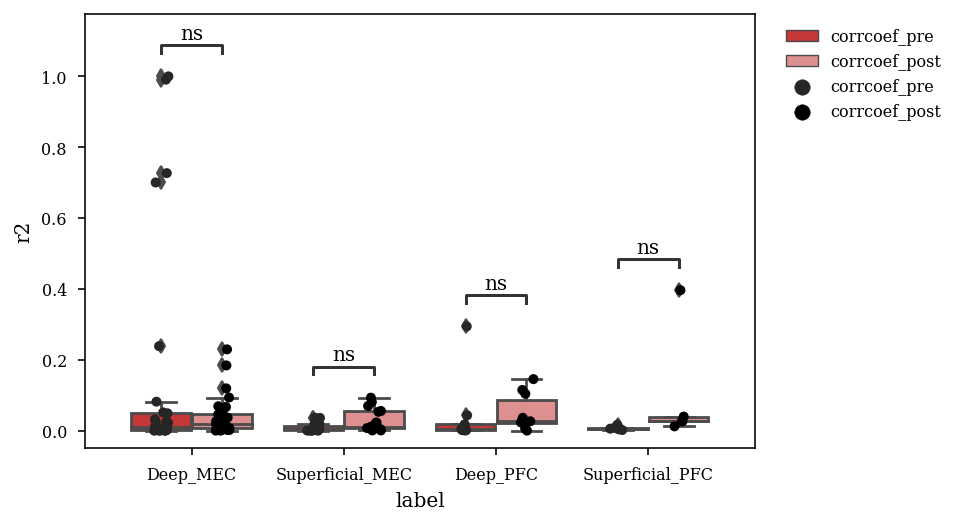

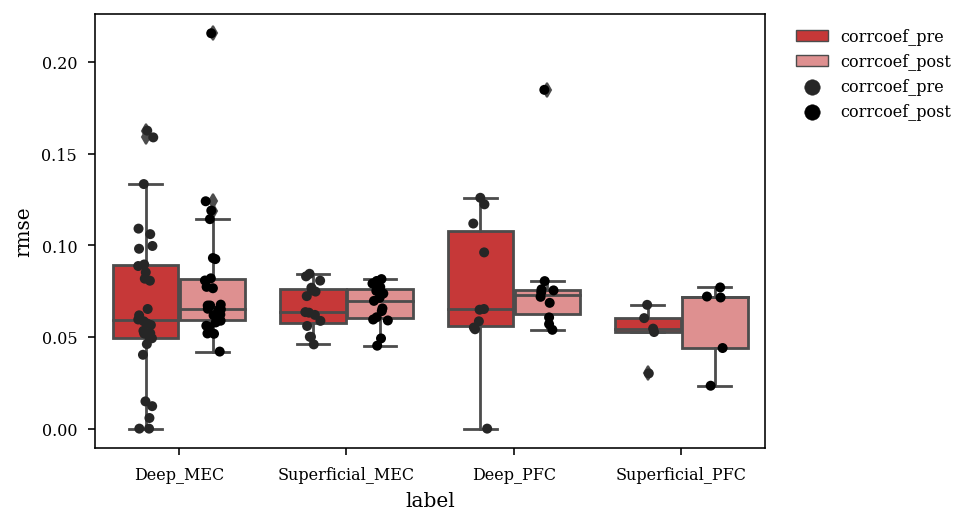

In [262]:

sns.boxplot(x="label", y="r2",hue="epoch_type", data=corr_df)
sns.stripplot(x="label", y="r2",hue="epoch_type",dodge=True, data=corr_df, color="black")
# plt.yscale("log")
plt.legend(
    bbox_to_anchor=(1.3, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)
box_pairs=[(("Deep_MEC","corrcoef_pre"), ("Deep_MEC","corrcoef_post")),
                (("Superficial_MEC","corrcoef_pre"), ("Superficial_MEC","corrcoef_post")),
                (("Deep_PFC","corrcoef_pre"), ("Deep_PFC","corrcoef_post")),
                (("Superficial_PFC","corrcoef_pre"), ("Superficial_PFC","corrcoef_post"))
            ]
add_stat_annotation(plt.gca(), x="label", y="r2",hue="epoch_type", data=corr_df,
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='inside', verbose=2)
plt.show()

sns.boxplot(x="label", y="rmse",hue="epoch_type", data=corr_df)
sns.stripplot(x="label", y="rmse",hue="epoch_type",dodge=True, data=corr_df, color="black")
# plt.yscale("log")
plt.legend(
    bbox_to_anchor=(1.3, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

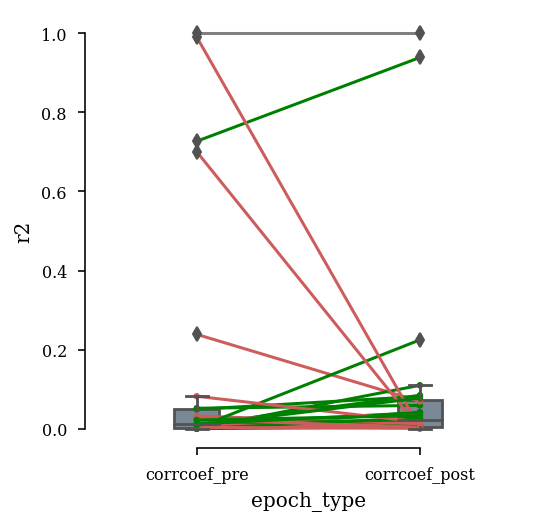

In [201]:
import pingouin as pg

fig, ax1 = plt.subplots(1, 1, figsize=(4, 4))
ax = pg.plot_paired(
    data=corr_df[corr_df.label == "Deep_MEC"],
    dv="r2",
    within="epoch_type",
    order=["corrcoef_pre", "corrcoef_post"],
    subject="basepath",
    ax=ax1,
)
# ax.set_yscale("log")


p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Deep_MEC v.s. Superficial_MEC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.245e-01 U_stat=1.200e+02
Deep_PFC v.s. Superficial_PFC: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=1.500e+01


(<AxesSubplot:xlabel='label', ylabel='Task vs. Post $R^2$ - Task vs. Pre $R^2$'>,
  <statannot.StatResult.StatResult at 0x21f906002e0>])

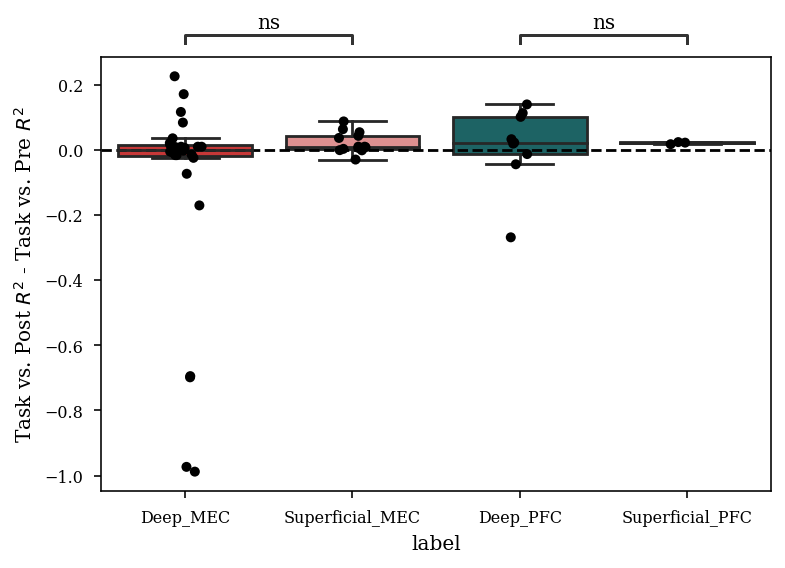

In [258]:
# corr_df[corr_df.epoch_type == "corrcoef_post"].r2 - corr_df[corr_df.epoch_type == "corrcoef_pre"].r2
# pivot corr_df on epoch_type
# corr_df_pivot = corr_df.pivot(index="label", columns="epoch_type", values="r2")
corr_df_pivot = pd.DataFrame()
corr_df_pivot['r2_diff'] = (corr_df[corr_df.epoch_type == "corrcoef_post"].r2.values - corr_df[corr_df.epoch_type == "corrcoef_pre"].r2.values)
corr_df_pivot['label'] = corr_df[corr_df.epoch_type == "corrcoef_post"].label.values
corr_df_pivot

sns.boxplot(x="label", y="r2_diff", data=corr_df_pivot,showfliers=False)
sns.stripplot(x="label", y="r2_diff", data=corr_df_pivot, color="black")
plt.axhline(0, color="black", linestyle="--")
plt.ylabel("Task vs. Post $R^2$ - Task vs. Pre $R^2$")

box_pairs=[(("Deep_MEC"), ("Superficial_MEC")),
                (("Deep_PFC"), ("Superficial_PFC")),
            ]
add_stat_annotation(plt.gca(),x="label", y="r2_diff", data=corr_df_pivot,
                    box_pairs=box_pairs,
                    test='Mann-Whitney', text_format='star', loc='outside', verbose=2)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

PFC_Deep v.s. PFC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.028e-02 U_stat=1.060e+08
MEC_Deep v.s. MEC_Superficial: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=3.376e-03 U_stat=4.505e+07


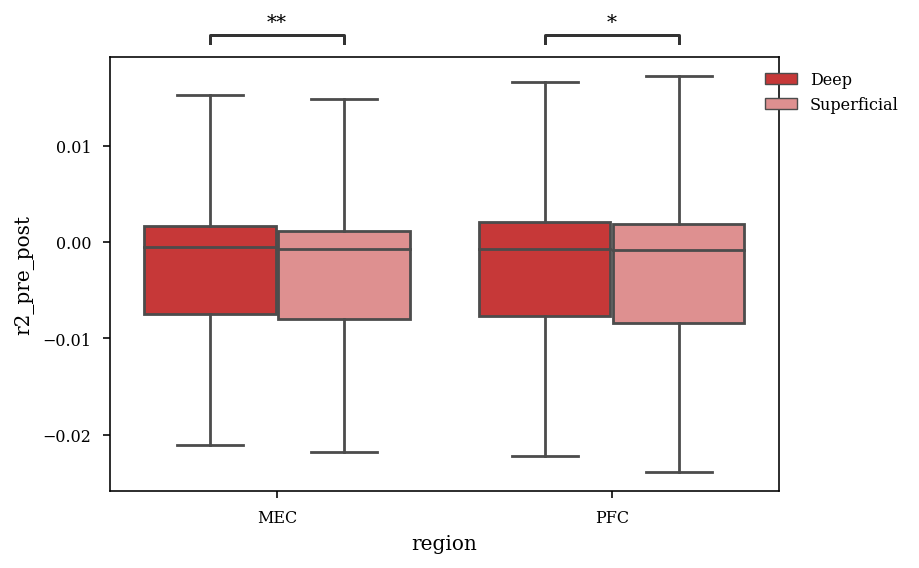

In [259]:
sns.boxplot(
    x="region",
    y="r2_pre_post",
    hue="sublayer",
    data=df_wide,
    showfliers=False,
)

# sns.stripplot(
#     x="region",
#     y="r2_pre_post",
#     hue="sublayer",
#     data=df_wide,
#     dodge=True,
# )
# plt.yscale("log")

box_pairs = [
    (("MEC", "Deep"), ("MEC", "Superficial")),
    (("PFC", "Deep"), ("PFC", "Superficial")),
]
add_stat_annotation(
    plt.gca(),
    x="region",
    y="r2_pre_post",
    hue="sublayer",
    data=df_wide,
    box_pairs=box_pairs,
    test="Mann-Whitney",
    text_format="star",
    loc="outside",
    verbose=2,
)
plt.legend(
    bbox_to_anchor=(1.2, 1),
    loc="upper right",
    fancybox=False,
    shadow=False,
    ncol=1,
    frameon=False,
)

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

Deep_MEC v.s. Superficial_MEC: t-test independent samples with Bonferroni correction, P_val=3.859e-06 stat=4.762e+00
Deep_PFC v.s. Superficial_PFC: t-test independent samples with Bonferroni correction, P_val=1.864e-15 stat=8.038e+00


(<AxesSubplot:xlabel='region_sublayer', ylabel='corrcoef_pre_post_abs'>,
  <statannot.StatResult.StatResult at 0x21f8f5679d0>])

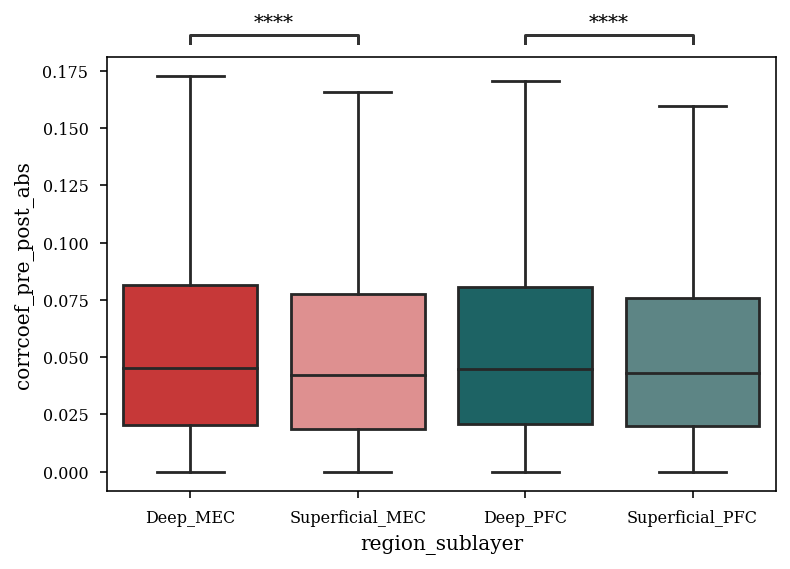

In [219]:

# df_wide["corrcoef_pre_post"] = (df_wide["corrcoef"]["pre"] - df_wide["corrcoef"]["post"]) / (df_wide["corrcoef"]["pre"] + df_wide["corrcoef"]["post"])


# df_wide["sup_ev_norm"] = df_wide["ev"]["Superficial"] - df_wide["rev"]["Superficial"]

sns.boxplot(x="region_sublayer", y="corrcoef_pre_post_abs", data=df_wide, showfliers=False)
# sns.stripplot(x="region_sublayer", y="corrcoef_pre_post", data=df_wide,dodge=True,color='k',alpha=.2)

box_pairs=[("Deep_MEC", "Superficial_MEC"), ("Deep_PFC", "Superficial_PFC")]
add_stat_annotation(plt.gca(),x="region_sublayer", y="corrcoef_pre_post_abs", data=df_wide,
                    box_pairs=box_pairs,
                    test='t-test_ind', text_format='star', loc='outside', verbose=2)

In [105]:
for basepath in df_wide.basepath.unique():
    df_wide.loc[df_wide.basepath == basepath, "animal_id"] = loading.get_animal_id(basepath)
    
df_wide["unique_uid_pair"] = df_wide.ref_uid.astype(str) + "_" + df_wide.target_uid.astype(str)
df_wide["unique_uid_basepath"] = df_wide.ref_uid.astype(str) + "_" + df_wide.basepath

In [106]:
df_wide.to_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\pairwise_corr_readout.csv")

In [44]:
np.unique((df_wide[df_wide.basepath == "Z:\Data\AYAold\AYA7\day19"].ref_uid * df_wide[df_wide.basepath == "Z:\Data\AYAold\AYA7\day19"].target_uid).values).shape

(190,)

In [67]:
df_wide.animal_id.unique()

array(['AYA7', 'AYA9', 'EE', 'HMC1', 'ec013', 'ec014', 'Kenji', 'ec016',
       'OR18'], dtype=object)

In [57]:

df_wide

basepath region sublayer region_sublayer  \
epoch                                                                 
0         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
1         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
2         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
3         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
4         Z:\Data\AYAold\AYA7\day19    MEC     Deep        Deep_MEC   
...                             ...    ...      ...             ...   
280988  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280989  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280990  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280991  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   
280992  Z:\Data\ORproject\OR18\day2    PFC     Deep        Deep_PFC   

       session_idx ref_uid target_uid  corrcoef                      \
epoch                                      post       pre      task   
0              0.0    57.0       87.0  0.115733  0.071743  0.022085   
1              1.0    57.0       89.0  0.063071  0.026452  0.000278   
2              2.0    57.0       90.0  0.086257  0.049039 -0.005033   
3              3.0    57.0       91.0 -0.000826  0.005640  0.015633   
4              4.0    57.0       92.0  0.048797  0.113637 -0.015339   
...            ...     ...        ...       ...       ...       ...   
280988       298.0    21.0       39.0  0.228201  0.391553 -0.017103   
280989       299.0    21.0       40.0  0.030981  0.134141  0.005404   
280990       300.0    21.0       45.0  0.090695  0.160112  0.031985   
280991       301.0    21.0       46.0  0.217487  0.308370  0.021767   
280992       302.0    21.0       49.0  0.124707  0.275539  0.057264   

       corrcoef_pre_post corrcoef_pre_post_abs r2_pre_post animal_id  \
epoch                                                                  
0              -0.043990              0.043990    0.001935      AYA7   
1              -0.036619              0.036619    0.001341      AYA7   
2              -0.037219              0.037219    0.001385      AYA7   
3               0.006465              0.006465    0.000042      AYA7   
4               0.064840              0.064840    0.004204      AYA7   
...                  ...                   ...         ...       ...   
280988          0.163352              0.163352    0.026684      OR18   
280989          0.103160              0.103160    0.010642      OR18   
280990          0.069417              0.069417    0.004819      OR18   
280991          0.090883              0.090883    0.008260      OR18   
280992          0.150832              0.150832    0.022750      OR18   

       unique_uid_pair               unique_uid_basepath  
epoch                                                     
0            57.0_87.0    57.0_Z:\Data\AYAold\AYA7\day19  
1            57.0_89.0    57.0_Z:\Data\AYAold\AYA7\day19  
2            57.0_90.0    57.0_Z:\Data\AYAold\AYA7\day19  
3            57.0_91.0    57.0_Z:\Data\AYAold\AYA7\day19  
4            57.0_92.0    57.0_Z:\Data\AYAold\AYA7\day19  
...                ...                               ...  
280988       21.0_39.0  21.0_Z:\Data\ORproject\OR18\day2  
280989       21.0_40.0  21.0_Z:\Data\ORproject\OR18\day2  
280990       21.0_45.0  21.0_Z:\Data\ORproject\OR18\day2  
280991       21.0_46.0  21.0_Z:\Data\ORproject\OR18\day2  
280992       21.0_49.0  21.0_Z:\Data\ORproject\OR18\day2  

[280993 rows x 16 columns]

<AxesSubplot:>

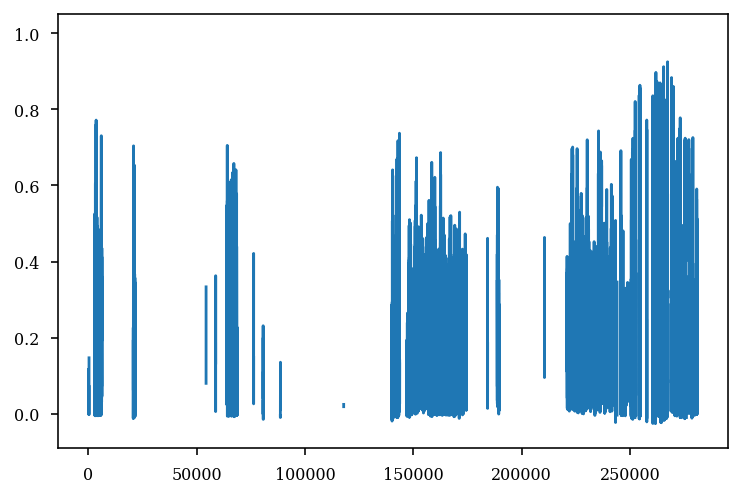

In [56]:
df_wide.corrcoef.post

In [41]:
df_wide[df_wide.basepath == "Z:\Data\AYAold\AYA7\day19"].target_uid.unique().shape

(9,)

In [10]:
from ripple_heterogeneity.readout import readout_explained_var
basepath = r"Z:\Data\HMC1\day8"
results = readout_explained_var.run(
    basepath,  # path to data folder
    reference_region="CA1",  # reference region
    target_regions=["PFC", "EC1|EC2|EC3|EC4|EC5|MEC"],  # regions to compare ref to
    min_cells=5,  # minimum number of cells per region
    restrict_task=False,  # restrict restriction_type to task epochs
    restriction_type="ripples",  # "ripples" or "NREMstate"
    ripple_expand=0.05,  # in seconds, how much to expand ripples
)

c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 159 last spike(s) of the input spiketrain
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 149 last spike(s) of the input spiketrain
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 92 last spike(s) of the input spiketrain
c:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\elephant\conversion.py:1168: UserWarning: Binning discarded 82 last spike(s) of the input spiketrain


In [16]:
results["pairwise_corr_df"][~np.isnan(results["pairwise_corr_df"]["corr"])]

,corr,epoch,region,sublayer,ref_uid,target_uid,basepath
175,0.385963,pre,PFC,Deep,1,184,Z:\Data\HMC1\day8
176,0.347254,pre,PFC,Deep,1,185,Z:\Data\HMC1\day8
177,0.357725,pre,PFC,Deep,1,188,Z:\Data\HMC1\day8
178,0.228768,pre,PFC,Deep,1,194,Z:\Data\HMC1\day8
179,0.352350,pre,PFC,Deep,1,195,Z:\Data\HMC1\day8
...,...,...,...,...,...,...,...
382870,0.166362,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,352,Z:\Data\HMC1\day8
382871,0.142686,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,353,Z:\Data\HMC1\day8
382872,0.043144,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,354,Z:\Data\HMC1\day8
382873,0.227871,post,EC1|EC2|EC3|EC4|EC5|MEC,Superficial,281,355,Z:\Data\HMC1\day8


In [3]:
basepath = r"Z:\Data\HMC1\day8"

st,cell_metrics = loading.load_spikes(basepath)

In [4]:
353**2

124609

In [8]:
import itertools

c = np.array(list(itertools.product(cell_metrics.UID.values, repeat=2)))
c[:,0]


array([  1,   1,   1, ..., 356, 356, 356], dtype=uint16)